In [1]:
!pip install datasets transformers[sentencepiece] sacrebleu -q


[notice] A new release of pip available: 22.2.1 -> 24.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [4]:
import os
import sys
import tensorflow as tf
import transformers
from datasets import load_dataset
from transformers import AutoTokenizer
from transformers import TFAutoModelForSeq2SeqLM, DataCollatorForSeq2Seq
from transformers import AdamWeightDecay

c:\Users\princ\Desktop\Deep Learning\PROJECTS\language-translator\env\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
model_checkpoint = "Helsinki-NLP/opus-mt-en-hi"

In [6]:
raw_datasets = load_dataset("cfilt/iitb-english-hindi")

In [7]:
raw_datasets['train'][0]

{'translation': {'en': 'Give your application an accessibility workout',
  'hi': 'अपने अनुप्रयोग को पहुंचनीयता व्यायाम का लाभ दें'}}

In [8]:
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)

c:\Users\princ\Desktop\Deep Learning\PROJECTS\language-translator\env\lib\site-packages\transformers\models\marian\tokenization_marian.py:175: UserWarning: Recommended: pip install sacremoses.
  warnings.warn("Recommended: pip install sacremoses.")
c:\Users\princ\Desktop\Deep Learning\PROJECTS\language-translator\env\lib\site-packages\transformers\tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [10]:
import pickle

with open('tokenizer.pkl', 'wb') as file:
    pickle.dump(tokenizer, file)

In [7]:
tokenizer("Hello, I am Prince Gupta")

{'input_ids': [12110, 2, 56, 489, 21997, 2797, 3958, 7595, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1]}

In [8]:
with tokenizer.as_target_tokenizer():
    print(tokenizer(["अपने अनुप्रयोग को पहुंचनीयता व्यायाम का लाभ दें"]))

{'input_ids': [[63, 2025, 18, 16155, 346, 20311, 24, 2279, 679, 0]], 'attention_mask': [[1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]}


c:\Users\princ\Desktop\Deep Learning\PROJECTS\language-translator\env\lib\site-packages\transformers\tokenization_utils_base.py:4126: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(


In [9]:
max_input_length = 128
max_target_length = 128

source_lang = "en"
target_lang = "hi"

def preprocess_data(examples):
    inputs = [ex[source_lang] for ex in examples["translation"]]
    targets = [ex[target_lang] for ex in examples["translation"]]
    model_inputs = tokenizer(inputs, max_length=max_input_length, truncation=True)

    with tokenizer.as_target_tokenizer():
        labels = tokenizer(targets, max_length=max_target_length, truncation=True)

    model_inputs["labels"] = labels["input_ids"]
    return model_inputs

In [10]:
preprocess_data(raw_datasets["train"][:2])

{'input_ids': [[3872, 85, 2501, 132, 15441, 36398, 0], [32643, 28541, 36253, 0]], 'attention_mask': [[1, 1, 1, 1, 1, 1, 1], [1, 1, 1, 1]], 'labels': [[63, 2025, 18, 16155, 346, 20311, 24, 2279, 679, 0], [26618, 16155, 346, 33383, 0]]}

In [11]:
tokenized_dataset = raw_datasets.map(preprocess_data, batched=True)

In [36]:
batch_size = 16
learning_rate = 2e-5
weight_decay = 0.01
num_train_epochs = 1

In [37]:
model = TFAutoModelForSeq2SeqLM.from_pretrained(model_checkpoint)

All model checkpoint layers were used when initializing TFMarianMTModel.

All the layers of TFMarianMTModel were initialized from the model checkpoint at Helsinki-NLP/opus-mt-en-hi.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFMarianMTModel for predictions without further training.


In [38]:
data_collator = DataCollatorForSeq2Seq(tokenizer, model, return_tensors="tf")

In [39]:
generation_data_collator = DataCollatorForSeq2Seq(tokenizer, model, return_tensors="tf", pad_to_multiple_of=128)

In [40]:
train_dataset = model.prepare_tf_dataset(
    tokenized_dataset["test"],
    batch_size=batch_size,
    shuffle=True,
    collate_fn = data_collator
)

In [41]:
validation_dataset = model.prepare_tf_dataset(
    tokenized_dataset["validation"],
    batch_size=batch_size,
    shuffle=False,
    collate_fn = data_collator
)

In [42]:
generation_dataset = model.prepare_tf_dataset(
    tokenized_dataset["validation"],
    batch_size=8,
    shuffle = False,
    collate_fn = generation_data_collator
)

In [43]:
optimzer = AdamWeightDecay(
    learning_rate=learning_rate,
    weight_decay_rate=weight_decay,
)

model.compile(optimzer)

In [44]:
history = model.fit(train_dataset, validation_data=validation_dataset, epochs=10)

Epoch 1/10
156/156 [==============================] - 258s 2s/step - loss: 3.7619 - val_loss: 3.9378
Epoch 2/10
156/156 [==============================] - 246s 2s/step - loss: 3.3127 - val_loss: 3.8592
Epoch 3/10
156/156 [==============================] - 239s 2s/step - loss: 3.0150 - val_loss: 3.8336
Epoch 4/10
156/156 [==============================] - 489s 3s/step - loss: 2.7814 - val_loss: 3.8231
Epoch 5/10
156/156 [==============================] - 236s 2s/step - loss: 2.5676 - val_loss: 3.8163
Epoch 6/10
156/156 [==============================] - 237s 2s/step - loss: 2.3786 - val_loss: 3.8275
Epoch 7/10
156/156 [==============================] - 829s 5s/step - loss: 2.1982 - val_loss: 3.8400
Epoch 8/10
156/156 [==============================] - 256s 2s/step - loss: 2.0604 - val_loss: 3.8572
Epoch 9/10
156/156 [==============================] - 261s 2s/step - loss: 1.9112 - val_loss: 3.8602
Epoch 10/10
156/156 [==============================] - 255s 2s/step - loss: 1.7819 - val_lo

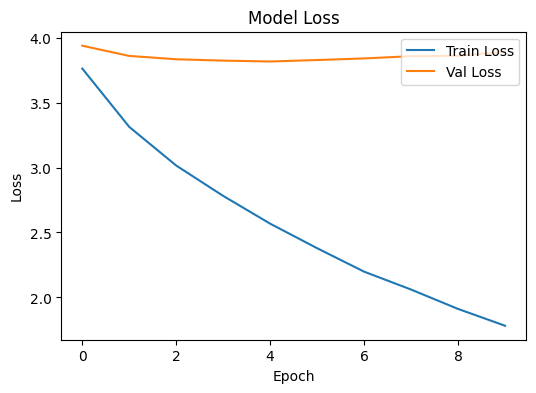

In [47]:
import matplotlib.pyplot as plt
plt.figure(figsize=(6, 4))

# # Plot training & validation loss values
# plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')

plt.show()

In [48]:
model.save_pretrained("tf_model/")

Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 512, 'num_beams': 4, 'bad_words_ids': [[61949]], 'forced_eos_token_id': 0}


In [49]:
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)
model = TFAutoModelForSeq2SeqLM.from_pretrained("tf_model/")

c:\Users\princ\Desktop\Deep Learning\PROJECTS\language-translator\env\lib\site-packages\transformers\models\marian\tokenization_marian.py:175: UserWarning: Recommended: pip install sacremoses.
  warnings.warn("Recommended: pip install sacremoses.")
c:\Users\princ\Desktop\Deep Learning\PROJECTS\language-translator\env\lib\site-packages\transformers\tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
All model checkpoint layers were used when initializing TFMarianMTModel.

All the layers of TFMarianMTModel were initialized from the model checkpoint at tf_model/.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFMarianMTModel for predictions without further 

In [56]:
input_text  = "Technology has dramatically transformed the way we live, work, and communicate.From smartphones to artificial intelligence, these advancements have reshaped every aspect of our daily lives, making tasks more efficient and information more accessible."

tokenized = tokenizer([input_text], return_tensors='np')
out = model.generate(**tokenized, max_length=128)
print(out)

tf.Tensor(
[[61949 34882    37   217  3190     2   358     2  1231 13152     6  1877
     11 30817   246    12  1382    78     5    40 11472 23292     6  4424
     12     2   281  4991    86    37   217 13524     6   451     6   266
   5249    18  3503  6327    78     5     2  1231   672  6705   358  1231
   1066   591    15     5    40     0 61949]], shape=(1, 55), dtype=int32)


In [57]:
with tokenizer.as_target_tokenizer():
    print(tokenizer.decode(out[0], skip_special_tokens=True))

प्रौद्योगिकी ने हमारे जीने, कार्य, तथा संचार के तरीके में नाटकीय रूप से परिवर्तन किया है। स्मार्टफोन के माध्यम से, इन प्रगतिों ने हमारे प्रतिदिन के जीवन के हर पहलू को पुनः परिवर्तित किया है, तथा अधिक कुशल कार्य तथा जानकारी प्राप्त की है।
